# Import Libraries

In [1]:
!pip install visualkeras
import visualkeras

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 989.9/989.9 kB 3.7 MB/s eta 0:00:00


In [2]:
!pip install split-folders
import splitfolders

In [3]:
import tensorflow as tf
import numpy as np
import os
import random
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix
from PIL import Image


from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import shutil

tfk = tf.keras
tfkl = tf.keras.layers
print(tf.__version__)

2.6.4


## Set The Seed

In [4]:
import warnings
import logging

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)
tf.get_logger().setLevel('INFO')
tf.autograph.set_verbosity(0)

tf.get_logger().setLevel(logging.ERROR)
tf.get_logger().setLevel('ERROR')
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

# Random seed for reproducibility
seed = 22

random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

# DataBase Management

In [5]:
labels = [
    "Species1",  #1
    "Species2",  #2
    "Species3",  #3
    "Species4",  #4
    "Species5",  #5
    "Species6",  #6
    "Species7",  #7
    "Species8",  #8
]

## Data Augmentation

In [6]:
dataset_dir = './dataset'

if not(os.path.exists(dataset_dir)) :
    print('splitting')
    
    splitfolders.fixed("../input/an2dl-data/training_data_final", 
                       output="dataset",
                       seed=seed, 
                       fixed=(30, 15), 
                       oversample=False, 
                       group_prefix=None, 
                       move=False)


print("Spit Done")

splitting


Copying files: 3542 files [00:20, 172.32 files/s]

Spit Done


In [7]:
def count_dir_files(dir):
    count_dir = {}
    for sp in labels:
        count_dir[sp] = len(os.listdir(dir+sp))

    return count_dir

In [8]:
def augm_img(dir_noaug,dir_aug,image_generator_train, img_cnt, labels):
    
    # Create a new directory and copy into it the content of the one splitted
    shutil.copytree('./'+dir_noaug, './'+dir_aug)
    
    count_dict = count_dir_files('./'+dir_noaug+'/train/')
    
    for lab in labels:
        count_to_reach = img_cnt - count_dict[lab]
        fin_iter = 0
        iterations = int(count_to_reach / count_dict[lab])
        if count_to_reach > count_dict[lab]:
            partial_tot = iterations*count_dict[lab]
            
            fin_iter = count_to_reach - partial_tot

        elif count_to_reach < count_dict[lab]:
            fin_iter = count_to_reach
        
        data_gen_spec = image_generator_train.flow_from_directory(directory='./'+dir_noaug+'/train',
                                                                  target_size = (96,96),
                                                                  color_mode = 'rgb',
                                                                  classes=[lab],
                                                                  batch_size=count_dict[lab],
                                                                  shuffle = True,
                                                                  save_to_dir='./'+dir_aug+'/train/'+lab,
                                                                  save_format='jpg',
                                                                  save_prefix="augmented")

        for i in range(iterations):
            data_gen_spec.next()
            
        if fin_iter != 0:
            data_gen_spec = image_generator_train.flow_from_directory(directory='./'+dir_noaug+'/train',
                                                                      target_size = (96,96),
                                                                      color_mode = 'rgb',
                                                                      classes=[lab],
                                                                      batch_size=fin_iter,
                                                                      shuffle = True,
                                                                      save_to_dir='./'+dir_aug+'/train/'+lab,
                                                                      save_format='jpg',
                                                                      save_prefix="augmented")
            data_gen_spec.next()

In [9]:
#Image Generator For Augmetation
image_generator_aug = ImageDataGenerator(rotation_range=90, 
                                         width_shift_range=0.3,
                                         height_shift_range=0.3,
                                         horizontal_flip=True,
                                         brightness_range=(0.7,1.1),
                                         vertical_flip=True,
                                         zoom_range=0.1, 
                                         fill_mode='reflect')

In [10]:
dataset_dir="./datasetAug"
training_dir = os.path.join(dataset_dir, 'train')
validation_dir = os.path.join(dataset_dir, 'val')
test_dir = os.path.join(dataset_dir, 'test')

In [11]:
augm_img('dataset','datasetAug',image_generator_aug, 4000, labels)
print("Augmentation Done")

Found 141 images belonging to 1 classes.
Found 141 images belonging to 1 classes.
Found 487 images belonging to 1 classes.
Found 487 images belonging to 1 classes.
Found 470 images belonging to 1 classes.
Found 470 images belonging to 1 classes.
Found 466 images belonging to 1 classes.
Found 466 images belonging to 1 classes.
Found 486 images belonging to 1 classes.
Found 486 images belonging to 1 classes.
Found 177 images belonging to 1 classes.
Found 177 images belonging to 1 classes.
Found 492 images belonging to 1 classes.
Found 492 images belonging to 1 classes.
Found 463 images belonging to 1 classes.
Found 463 images belonging to 1 classes.
Augmentation Done


In [12]:
count_dir_files(dataset_dir+"/train/")

{'Species1': 4000,
 'Species2': 4000,
 'Species3': 4000,
 'Species4': 4000,
 'Species5': 4000,
 'Species6': 4000,
 'Species7': 4000,
 'Species8': 4000}

## Database Retrive

In [13]:
image_generator_preprocessing = ImageDataGenerator(preprocessing_function=preprocess_input)


train_data = image_generator_preprocessing.flow_from_directory(training_dir,
                                                       target_size = (96,96),
                                                       color_mode = 'rgb',
                                                       classes = None,
                                                       batch_size = 64,
                                                       shuffle = True,
                                                       seed = seed)

validation_data = image_generator_preprocessing.flow_from_directory(validation_dir,
                                                                 target_size = (96,96),
                                                                 color_mode = 'rgb',
                                                                 classes = None,
                                                                 batch_size = 64,
                                                                 shuffle = False,
                                                                 seed = seed)

test_data = image_generator_preprocessing.flow_from_directory(test_dir,
                                                     target_size = (96,96),
                                                     color_mode = 'rgb',
                                                     classes = None,
                                                     batch_size = 16,
                                                     shuffle = False,
                                                     seed = seed)

Found 32000 images belonging to 8 classes.
Found 240 images belonging to 8 classes.
Found 120 images belonging to 8 classes.


### Show A Sample of the Dataset

(Input) image shape: (64, 96, 96, 3)
Target shape: (64, 8)

Categorical label: [1. 0. 0. 0. 0. 0. 0. 0.]
Label: 0
Class name: Species1


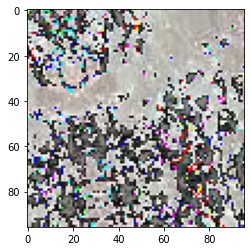

In [14]:
# Get a sample from dataset and show info
def get_next_batch(generator):
  batch = next(generator)
  image = batch[0]
  target = batch[1]
  print("(Input) image shape:", image.shape)
  print("Target shape:",target.shape)
  # Visualize only the first sample
  image = image[1]
  target = target[0]
  target_idx = np.argmax(target)
  print()
  print("Categorical label:", target)
  print("Label:", target_idx)
  print("Class name:", labels[target_idx])
  fig = plt.figure(figsize=(6, 4))
  plt.imshow(np.uint8(image))
  return batch
_ = get_next_batch(train_data)

# Model Management

In [15]:
input_shape = (96, 96, 3)
#Supernet Parameter
supernet_input_shape = (96,96,3)

In [16]:
#Import the Model used for Transfer Learning
supernet=tf.keras.applications.VGG16(
    include_top=False,
    weights="imagenet",
    input_tensor=None,
    input_shape=supernet_input_shape,
    pooling=None
)

supernet.trainable = False

58900480/58889256 [==============================] - 0s 0us/step


In [17]:
#print the layer of the supernet
for i, layer in enumerate(supernet.layers):
   print(i, layer.name, layer.trainable)

0 input_1 False
1 block1_conv1 False
2 block1_conv2 False
3 block1_pool False
4 block2_conv1 False
5 block2_conv2 False
6 block2_pool False
7 block3_conv1 False
8 block3_conv2 False
9 block3_conv3 False
10 block3_pool False
11 block4_conv1 False
12 block4_conv2 False
13 block4_conv3 False
14 block4_pool False
15 block5_conv1 False
16 block5_conv2 False
17 block5_conv3 False
18 block5_pool False


## Define The Top Model

In [18]:
dropoutrate = 0.35
elastic_lambda = 5e-4
learning_rate=5e-4

In [19]:
input_layer = tfk.Input(shape=input_shape,name="input_layer")

resize = tfkl.Resizing(supernet_input_shape[0], supernet_input_shape[1], interpolation="bicubic")(input_layer)

x = supernet(resize)

x = tfkl.GlobalAveragePooling2D(name='GlobalPooling')(x)

x = tfkl.BatchNormalization()(x)

classifier_layer1 = tfkl.Dense(units=256,
                               name='Classifier1', 
                               activation=tfkl.LeakyReLU(),
                               kernel_regularizer=tf.keras.regularizers.L1L2(elastic_lambda,elastic_lambda),
                               kernel_initializer=tfk.initializers.GlorotUniform(seed),
                              )(x)
    
classifier_layer1 = tfkl.Dropout(dropoutrate, seed=seed)(classifier_layer1)
    
output_layer = tfkl.Dense(units=8,
                          name='output_layer',
                          activation='softmax',
                          kernel_initializer=tfk.initializers.GlorotUniform(seed),
                          )(classifier_layer1)

# Connect input and output through the Model class
model = tfk.Model(inputs=input_layer, outputs=output_layer, name='model')

# Compile the model
model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(learning_rate), metrics='accuracy')
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 96, 96, 3)]       0         
_________________________________________________________________
resizing (Resizing)          (None, 96, 96, 3)         0         
_________________________________________________________________
vgg16 (Functional)           (None, 3, 3, 512)         14714688  
_________________________________________________________________
GlobalPooling (GlobalAverage (None, 512)               0         
_________________________________________________________________
batch_normalization (BatchNo (None, 512)               2048      
_________________________________________________________________
Classifier1 (Dense)          (None, 256)               131328    
_________________________________________________________________
dropout (Dropout)            (None, 256)               0     

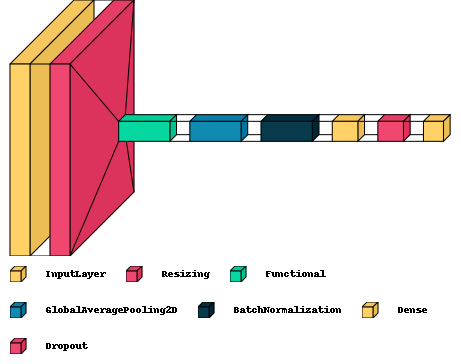

In [20]:
visualkeras.layered_view(model, legend=True, spacing=20, scale_xy=2)

In [21]:
callbacks = []
# Early Stopping
# --------------
es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', 
                                               patience=12, 
                                               restore_best_weights=True)
callbacks.append(es_callback)

# ReduceLROnPlateau
# -----------------
red_lr_callback = tfk.callbacks.ReduceLROnPlateau(monitor='val_loss', patience=5,factor=0.3)
callbacks.append(red_lr_callback)

In [22]:
# Train the model
history = model.fit(
    x = train_data,
    epochs = 100,
    validation_data = validation_data,
    callbacks = callbacks,
).history
print("END TRAINING")

Epoch 1/100
500/500 [==============================] - 36s 55ms/step - loss: 3.7622 - accuracy: 0.5286 - val_loss: 3.0535 - val_accuracy: 0.5917
Epoch 2/100
500/500 [==============================] - 26s 53ms/step - loss: 2.4061 - accuracy: 0.6193 - val_loss: 2.1319 - val_accuracy: 0.5875
Epoch 3/100
500/500 [==============================] - 26s 52ms/step - loss: 1.6943 - accuracy: 0.6343 - val_loss: 1.6265 - val_accuracy: 0.6083
Epoch 4/100
500/500 [==============================] - 26s 52ms/step - loss: 1.4074 - accuracy: 0.6411 - val_loss: 1.4747 - val_accuracy: 0.6292
Epoch 5/100
500/500 [==============================] - 27s 53ms/step - loss: 1.3247 - accuracy: 0.6423 - val_loss: 1.3983 - val_accuracy: 0.6375
Epoch 6/100
500/500 [==============================] - 26s 53ms/step - loss: 1.2975 - accuracy: 0.6400 - val_loss: 1.3892 - val_accuracy: 0.6375
Epoch 7/100
500/500 [==============================] - 26s 52ms/step - loss: 1.2796 - accuracy: 0.6435 - val_loss: 1.3967 - val_ac

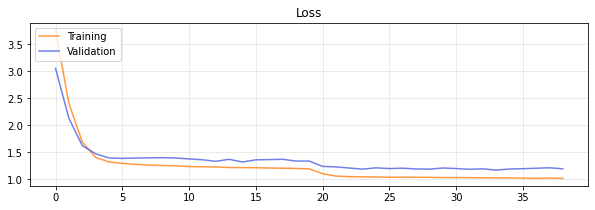

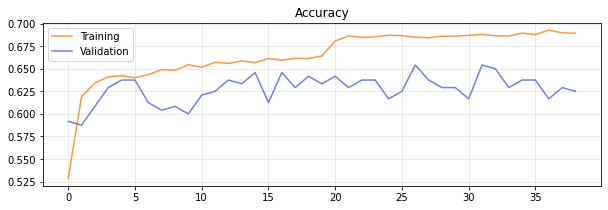

In [23]:
# Plot the training

plt.figure(figsize=(10,3))
plt.plot(history['loss'], label='Training', alpha=.8, color='#ff7f0e')
plt.plot(history['val_loss'], label='Validation', alpha=.8, color='#4D61E2')
plt.legend(loc='upper left')
plt.title('Loss')
plt.grid(alpha=.3)

plt.figure(figsize=(10,3))
plt.plot(history['accuracy'], label='Training', alpha=.8, color='#ff7f0e')
plt.plot(history['val_accuracy'], label='Validation', alpha=.8, color='#4D61E2')
plt.legend(loc='upper left')
plt.title('Accuracy')
plt.grid(alpha=.3)

plt.show()

In [24]:
name="modello256"+"preFineTuning"

In [25]:
model.save(name)
del model

## Fine Tuning

In [26]:
def callback():
    callbacks = []

    # Early Stopping
    # --------------
    es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', 
                                                   patience=10, 
                                                   restore_best_weights=True)
    callbacks.append(es_callback)

    # ReduceLROnPlateau
    # -----------------
    red_lr_callback = tfk.callbacks.ReduceLROnPlateau(monitor='val_loss', patience=5,factor=0.2)
    callbacks.append(red_lr_callback)
    return callbacks

In [27]:
def create_regularization_loss(weights, regularizer):
    return lambda: regularizer(weights)

def add_regularization(model, regularizer): 
    print("\nRegularized Layer Before: "+str(len(model.losses)))
    for layer in model.layers:
        if hasattr(layer, "kernel") and layer.trainable and len(layer.losses)<1:
            layer.add_loss(create_regularization_loss(layer.kernel,regularizer))
    print("Regularized Layer After: "+str(len(model.losses))+"\n")
    

In [28]:
def train_with_different_trainable_layer():
    models=[]
    setofhistory=[]
    NonTrainable = [3,10]
    for i in NonTrainable:
        print("1)LOAD MODEL for test with "+str(i)+" Non Trainable Layer")
        model = tfk.models.load_model('./'+name)
        #model = TrasfertLearningModel
        
        print("\n2)SET TRAINABLE LAYER")
        supernet  = model.get_layer(index=2)
        supernet.trainable = True
        trainable = len(supernet.layers)-i;
        first_non_Trainable_layer = i;
        for j, layer in enumerate(supernet.layers[:first_non_Trainable_layer+1]):
            if j==0:
                layer.trainable=True
            else:
                layer.trainable=False
        
        #Find to Be Useless
        #add_regularization(supernet,tf.keras.regularizers.L1L2(2e-5));
        
        print("\t total layers: "+str(len(supernet.layers)))
        print("\t trainable layers: "+str(trainable)+"\n\t Non Trainable Par: "+str(first_non_Trainable_layer))
        
        model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(5e-5), metrics='accuracy')
        
        print("\n3)TIME T0 TRAIN: "+str(i)+" Non Trainable")
        
        history = model.fit(
            x = train_data,
            epochs = 100,
            validation_data = validation_data,
            callbacks = callback(),
            verbose = 2
        ).history
        print("save current model\n")
        
        name1="FineTuning-"+str(i)
        model.save(name1)
        
        models.append(model)
        setofhistory.append(history)
    
    print("END OF THE FINE TUNING PHASE")
    return (models,setofhistory) 

    

In [29]:
(modelset,setofhistory) = train_with_different_trainable_layer()

1)LOAD MODEL for test with 3 Non Trainable Layer

2)SET TRAINABLE LAYER
	 total layers: 19
	 trainable layers: 16
	 Non Trainable Par: 3

3)TIME T0 TRAIN: 3 Non Trainable
Epoch 1/100
500/500 - 35s - loss: 0.7666 - accuracy: 0.7842 - val_loss: 0.7411 - val_accuracy: 0.8375
Epoch 2/100
500/500 - 33s - loss: 0.4560 - accuracy: 0.8914 - val_loss: 0.6968 - val_accuracy: 0.8083
Epoch 3/100
500/500 - 32s - loss: 0.3124 - accuracy: 0.9414 - val_loss: 0.9271 - val_accuracy: 0.7750
Epoch 4/100
500/500 - 32s - loss: 0.2289 - accuracy: 0.9678 - val_loss: 0.8947 - val_accuracy: 0.8167
Epoch 5/100
500/500 - 33s - loss: 0.1873 - accuracy: 0.9787 - val_loss: 1.0314 - val_accuracy: 0.7917
Epoch 6/100
500/500 - 33s - loss: 0.1561 - accuracy: 0.9864 - val_loss: 0.7826 - val_accuracy: 0.8292
Epoch 7/100
500/500 - 33s - loss: 0.1298 - accuracy: 0.9920 - val_loss: 0.8093 - val_accuracy: 0.8083
Epoch 8/100
500/500 - 33s - loss: 0.0994 - accuracy: 0.9984 - val_loss: 0.5989 - val_accuracy: 0.8750
Epoch 9/100
5

PRINT MODEL STATS:


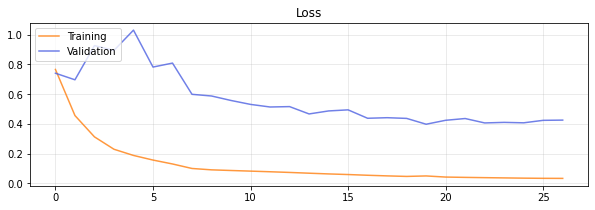

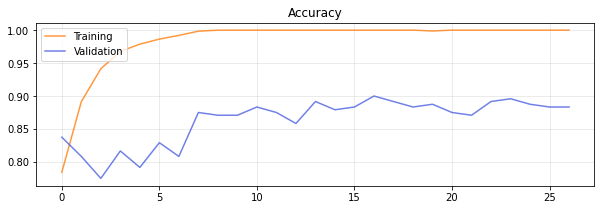

PRINT MODEL STATS:


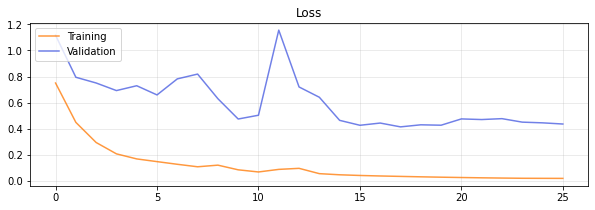

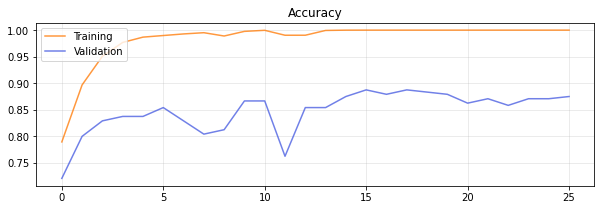

In [30]:
# Plot the training

for history in setofhistory:
    
    print("PRINT MODEL STATS:")
    plt.figure(figsize=(10,3))
    plt.plot(history['loss'], label='Training', alpha=.8, color='#ff7f0e')
    plt.plot(history['val_loss'], label='Validation', alpha=.8, color='#4D61E2')
    plt.legend(loc='upper left')
    plt.title('Loss')
    plt.grid(alpha=.3)

    plt.figure(figsize=(10,3))
    plt.plot(history['accuracy'], label='Training', alpha=.8, color='#ff7f0e')
    plt.plot(history['val_accuracy'], label='Validation', alpha=.8, color='#4D61E2')
    plt.legend(loc='upper left')
    plt.title('Accuracy')
    plt.grid(alpha=.3)

    plt.show()


PLOTTING NEW MODEL:

Confusion Matrix


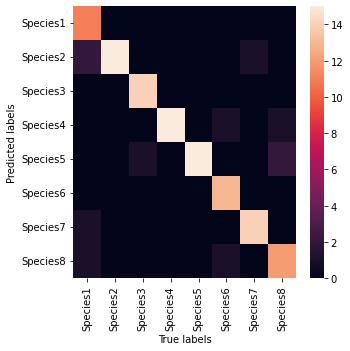



8/8 [==============================] - 0s 15ms/step - loss: 0.3895 - accuracy: 0.9083

              precision    recall  f1-score   support

           0       1.00      0.73      0.85        15
           1       0.83      1.00      0.91        15
           2       1.00      0.93      0.97        15
           3       0.88      1.00      0.94        15
           4       0.83      1.00      0.91        15
           5       1.00      0.87      0.93        15
           6       0.93      0.93      0.93        15
           7       0.86      0.80      0.83        15

    accuracy                           0.91       120
   macro avg       0.92      0.91      0.91       120
weighted avg       0.92      0.91      0.91       120


PLOTTING NEW MODEL:

Confusion Matrix


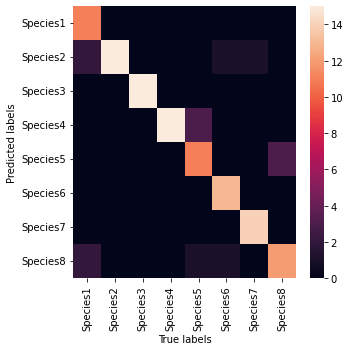



8/8 [==============================] - 0s 14ms/step - loss: 0.4077 - accuracy: 0.8833

              precision    recall  f1-score   support

           0       1.00      0.73      0.85        15
           1       0.79      1.00      0.88        15
           2       1.00      1.00      1.00        15
           3       0.83      1.00      0.91        15
           4       0.79      0.73      0.76        15
           5       1.00      0.87      0.93        15
           6       1.00      0.93      0.97        15
           7       0.75      0.80      0.77        15

    accuracy                           0.88       120
   macro avg       0.89      0.88      0.88       120
weighted avg       0.89      0.88      0.88       120



In [31]:
for model in modelset:
    print("\nPLOTTING NEW MODEL:\n")
    Y_pred = model.predict(test_data)
    y_pred = np.argmax(Y_pred, axis=1)
    print('Confusion Matrix')
    cm=confusion_matrix(test_data.classes, y_pred)
    #print(cm.T)
    plt.figure(figsize=(5,5))
    sns.heatmap(cm.T, xticklabels=labels, yticklabels=labels)
    plt.xlabel('True labels')
    plt.ylabel('Predicted labels')
    plt.show()

    print("\n")
    metrics = model.evaluate(validation_data, return_dict=True)
    metrics = model.evaluate(test_data, return_dict=True)
    print()
    print(classification_report(test_data.classes, y_pred))